# Investigating TV Series ratings using IMDB

In [1]:
import imdb

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from adjustText import adjust_text

from tqdm.auto import tqdm

In [2]:
sns.set_context('talk')

## Load ratings

In [3]:
query_list = [
    'Lost',
    'Game of Thrones',
    'Stargate SG-1', 'Stargate: Atlantis', 'Stargate Universe', 
    'Westworld'
]

In [4]:
ia = imdb.IMDb()

In [5]:
kind = 'tv series'
series_list = [x for query in query_list for x in ia.search_movie(query) if x['kind'] == kind and x['title'] == query]

assert len(query_list) == len(series_list)

In [6]:
series_list

[<Movie id:0411008[http] title:_"Lost" (2004)_>,
 <Movie id:0944947[http] title:_"Game of Thrones" (2011)_>,
 <Movie id:0118480[http] title:_"Stargate SG-1" (1997)_>,
 <Movie id:0374455[http] title:_"Stargate: Atlantis" (2004)_>,
 <Movie id:1286039[http] title:_"Stargate Universe" (2009)_>,
 <Movie id:0475784[http] title:_"Westworld" (2016)_>]

In [7]:
tmp = []
for series in tqdm(series_list, desc='Series'):
    tqdm.write(series['title'])
    ia.update(series, 'episodes')
    
    for season_nr in series['episodes']:
        season = series['episodes'][season_nr]
        
        for episode_nr in series['episodes'][season_nr]:
            episode = season[episode_nr]
            
            tmp.append({
                'series': series['title'],
                'season_nr': season_nr,
                'episode_nr': episode_nr,
                'episode': episode['title'],
                'rating': episode.get('rating', np.nan),
                'date': pd.to_datetime(episode.get('original air date')),
                # 'raw': series.data['episodes'][season][episode]
            })

df = pd.DataFrame(tmp).sort_values(by=['series', 'season_nr', 'episode_nr'])
df['idx'] = pd.Categorical(df['season_nr'].map(str) + ':' + df['episode_nr'].map(str))

Lost
Game of Thrones
Stargate SG-1
Stargate: Atlantis
Stargate Universe
Westworld



In [8]:
df.head()

,date,episode,episode_nr,rating,season_nr,series,idx
124,2011-04-17,Winter Is Coming,1,9.001235,1,Game of Thrones,1:1
125,2011-04-24,The Kingsroad,2,8.801235,1,Game of Thrones,1:2
126,2011-05-01,Lord Snow,3,8.701235,1,Game of Thrones,1:3
127,2011-05-08,"Cripples, Bastards, and Broken Things",4,8.801235,1,Game of Thrones,1:4
128,2011-05-15,The Wolf and the Lion,5,9.101235,1,Game of Thrones,1:5


## Visualize results

In [9]:
def annotate_episode(entry, ax, m):
    return ax.annotate(
        entry.episode,
        xy=(entry.idx, entry.rating), xytext=(0, 10*m),
        xycoords='data', textcoords='offset points',
        fontsize=10, ha='center', va='center',
        arrowprops=dict(arrowstyle='->')
    )

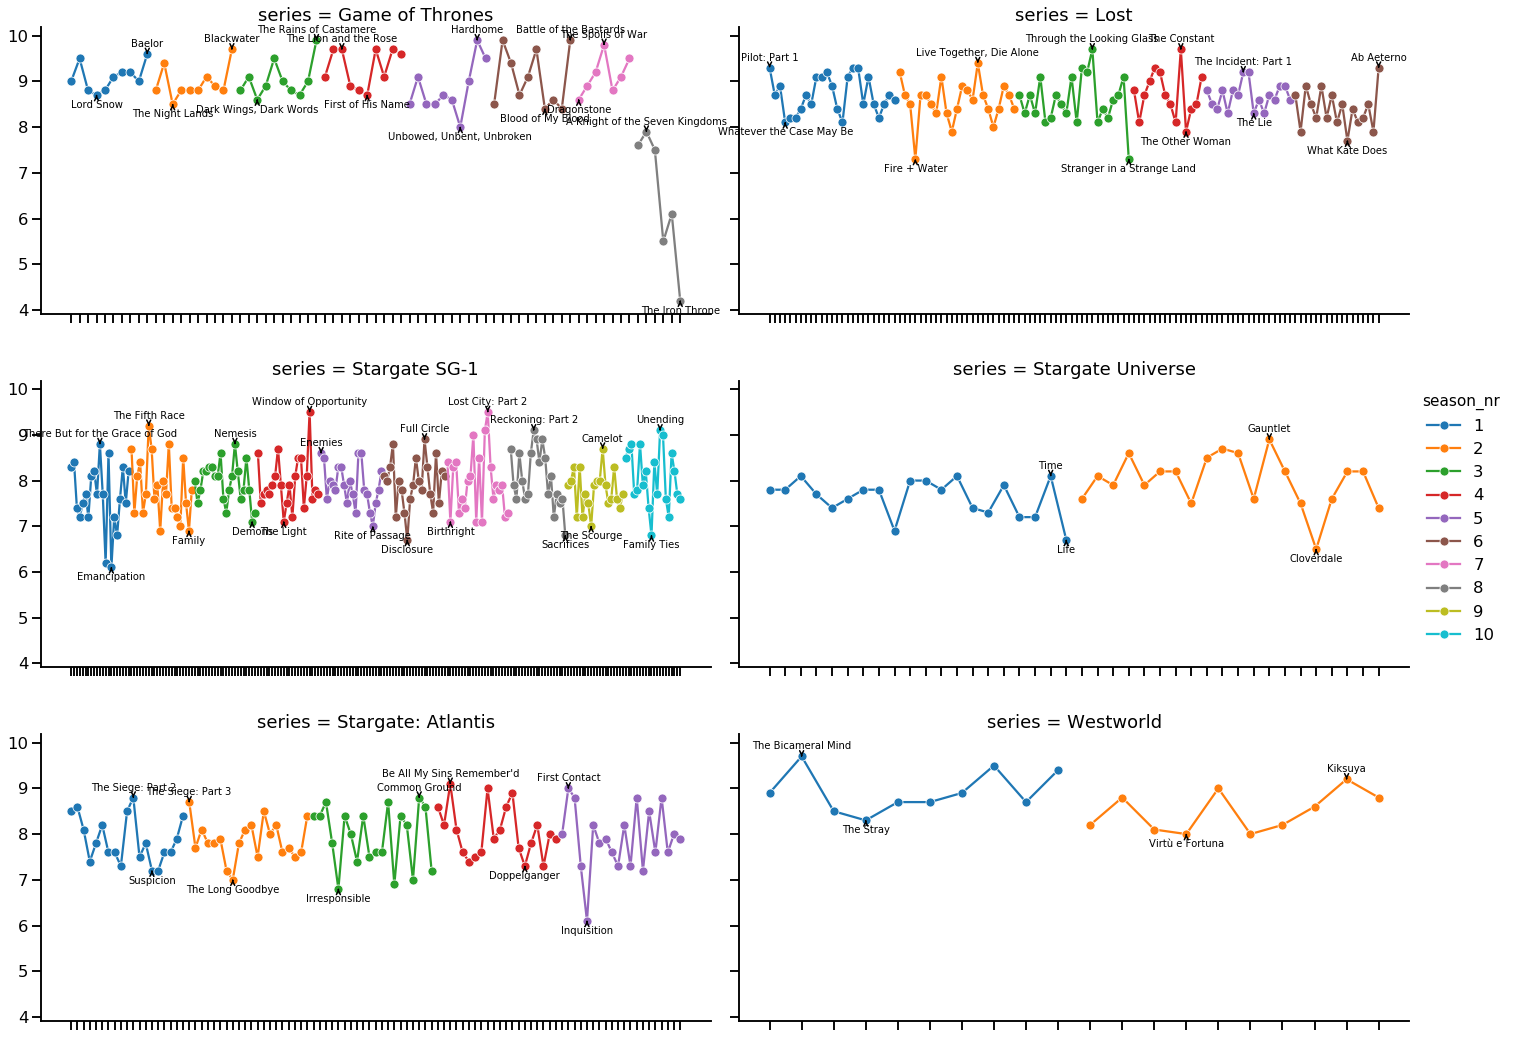

In [14]:
g = sns.FacetGrid(
    df.dropna(),
    col='series', col_wrap=2,
    hue='season_nr',
    sharex=False, sharey=True,
    aspect=2, height=5)

g.map_dataframe(sns.lineplot, x='idx', y='rating', marker='o', estimator=None)

g.set_xticklabels([])
g.add_legend()

# annotate episodes
texts = []
for (i, j, k), data in g.facet_data():
    # row, col, hue
    ax = g.facet_axis(i, j)
    
    if not data.empty:
        bt = annotate_episode(data.loc[data['rating'].idxmax()], ax, 1)
        wt = annotate_episode(data.loc[data['rating'].idxmin()], ax, -1)
        texts.extend([bt, wt])